In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

In [2]:
# Load the breast cancer dataset into a Pandas dataframe
df = pd.read_csv('breast-cancer.csv')

# Extract the features and target
X = df.drop(['id', 'diagnosis'], axis=1).values
y = LabelEncoder().fit_transform(df['diagnosis'].values)

# Split the dataset into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Custom PyTorch dataset
class CancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# PyTorch dataloaders for the training and testing sets created
train_dataset = CancerDataset(X_train, y_train)
test_dataset = CancerDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
c = Counter(y_train)

In [4]:
print(c)

Counter({0: 286, 1: 169})


In [5]:
#summary statistics
summary_stats = df.describe()

# Print summary statistics
print("Summary Statistics for the Dataset:")
display(summary_stats)


Summary Statistics for the Dataset:


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [24]:
class MLP_one_layer(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Instantiate the model and define the loss and optimizer
model_one_layer = MLP_one_layer(input_dim=X.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_one_layer.parameters(), lr=0)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model_one_layer(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

# Evaluate the model
model_one_layer.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_dataloader:
        y_pred = model_one_layer(X_batch)
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    print(f"Accuracy on test set: {(100 * correct / total):.2f}%")

Epoch [1/100], Step [10/15], Loss: 0.7999
Epoch [2/100], Step [10/15], Loss: 0.7972
Epoch [3/100], Step [10/15], Loss: 0.7980
Epoch [4/100], Step [10/15], Loss: 0.8120
Epoch [5/100], Step [10/15], Loss: 0.8068
Epoch [6/100], Step [10/15], Loss: 0.7434
Epoch [7/100], Step [10/15], Loss: 0.7625
Epoch [8/100], Step [10/15], Loss: 0.8892
Epoch [9/100], Step [10/15], Loss: 0.7959
Epoch [10/100], Step [10/15], Loss: 0.7920
Epoch [11/100], Step [10/15], Loss: 0.8607
Epoch [12/100], Step [10/15], Loss: 0.7977
Epoch [13/100], Step [10/15], Loss: 0.7945
Epoch [14/100], Step [10/15], Loss: 0.7598
Epoch [15/100], Step [10/15], Loss: 0.7466
Epoch [16/100], Step [10/15], Loss: 0.8194
Epoch [17/100], Step [10/15], Loss: 0.7506
Epoch [18/100], Step [10/15], Loss: 0.7803
Epoch [19/100], Step [10/15], Loss: 0.7471
Epoch [20/100], Step [10/15], Loss: 0.7860
Epoch [21/100], Step [10/15], Loss: 0.8238
Epoch [22/100], Step [10/15], Loss: 0.8310
Epoch [23/100], Step [10/15], Loss: 0.8305
Epoch [24/100], Step

In [7]:
# Define the multilayer perceptron model
class MLP(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 2)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model and define the loss and optimizer
model = MLP(input_dim=X.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X_batch, y_batch in test_dataloader:
        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    print(f'Accuracy on test set: {(100 * correct / total):.2f}%')


Epoch [1/100], Step [10/15], Loss: 0.6206
Epoch [2/100], Step [10/15], Loss: 0.4529
Epoch [3/100], Step [10/15], Loss: 0.3732
Epoch [4/100], Step [10/15], Loss: 0.2750
Epoch [5/100], Step [10/15], Loss: 0.2628
Epoch [6/100], Step [10/15], Loss: 0.1243
Epoch [7/100], Step [10/15], Loss: 0.1728
Epoch [8/100], Step [10/15], Loss: 0.0924
Epoch [9/100], Step [10/15], Loss: 0.0742
Epoch [10/100], Step [10/15], Loss: 0.1893
Epoch [11/100], Step [10/15], Loss: 0.1011
Epoch [12/100], Step [10/15], Loss: 0.0283
Epoch [13/100], Step [10/15], Loss: 0.0200
Epoch [14/100], Step [10/15], Loss: 0.0971
Epoch [15/100], Step [10/15], Loss: 0.0470
Epoch [16/100], Step [10/15], Loss: 0.0307
Epoch [17/100], Step [10/15], Loss: 0.0065
Epoch [18/100], Step [10/15], Loss: 0.0123
Epoch [19/100], Step [10/15], Loss: 0.0659
Epoch [20/100], Step [10/15], Loss: 0.0256
Epoch [21/100], Step [10/15], Loss: 0.0167
Epoch [22/100], Step [10/15], Loss: 0.0207
Epoch [23/100], Step [10/15], Loss: 0.1134
Epoch [24/100], Step

In [8]:
# Train SVM model
svm_model_4 = SVC(kernel='poly', C=1.0, degree=3, random_state=42)
svm_model_4.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model_4.predict(X_test)
accuracy_4 = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy_4:.4f}%')

SVM Accuracy: 0.8684%


In [9]:
# Train SVM model with other hyperparameter iterations
svm_model_5 = SVC(kernel='rbf', C=0.2, gamma=0.1, class_weight='balanced', random_state=42)
svm_model_5.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model_5.predict(X_test)
accuracy_5 = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy_5:.4f}%')

SVM Accuracy: 0.9035%


In [10]:
# Train SVM model with other hyperparameter iterations
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy:.4f}%')

SVM Accuracy: 0.9561%


In [11]:
# Train SVM model with other hyperparameter iterations
svm_model_2 = SVC(kernel='rbf', C=1.0, gamma=0.1, random_state=42)
svm_model_2.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model_2.predict(X_test)
accuracy_2 = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy_2:.4f}%')

SVM Accuracy: 0.9649%


In [12]:
# Train SVM model with other hyperparameter iterations
svm_model_3 = SVC(kernel='linear', C=0.1, class_weight='balanced', random_state=42)
svm_model_3.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model_3.predict(X_test)
accuracy_3 = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy_3:.4f}%')

SVM Accuracy: 0.9737%


In [13]:
# Train SVM model with other hyperparameter iterations
svm_model_1 = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model_1.fit(X_train, y_train)

# Evaluate the SVM model
y_pred = svm_model_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)
print(f'SVM Accuracy: {accuracy_1:.4f}%')


SVM Accuracy: 0.9825%


In [14]:
#Defult gamma Value
1 / ( 30 * X_test.var())

0.035540041279818725

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



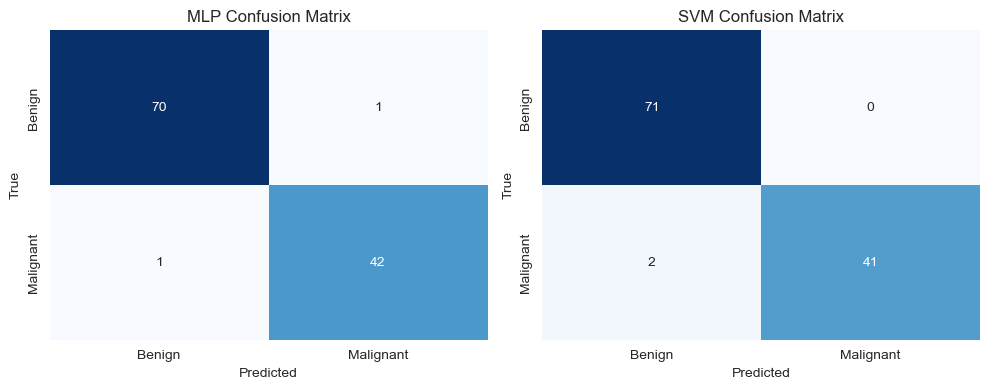

In [16]:
y_true = y_test
mlp_y_pred = model(torch.tensor(X_test.astype("float32")))
svm_y_pred = svm_model_1.predict(X_test)

mlp_y_pred =torch.max(mlp_y_pred,1)[1].detach().numpy()
# Compute confusion matrices
mlp_cm = confusion_matrix(y_true, mlp_y_pred)
svm_cm = confusion_matrix(y_true, svm_y_pred)

#Plot confusion matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(mlp_cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MLP Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(svm_cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')

plt.tight_layout()
plt.show()

In [17]:
mlp_y_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1])

In [18]:
svm_y_pred.shape

(114,)

In [19]:
y_true.shape

(114,)

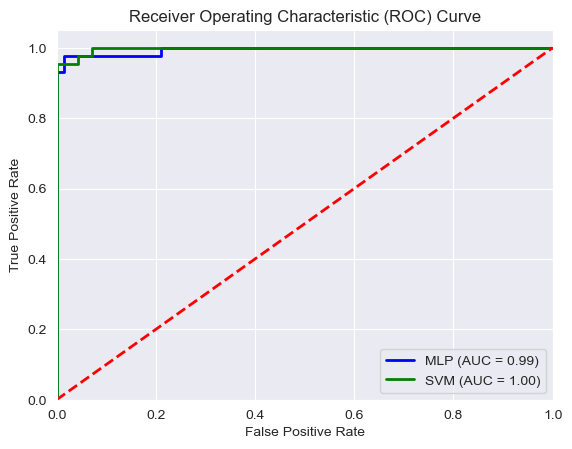

In [20]:
# Calculate the probabilities for each class
mlp_y_proba = model(torch.tensor(X_test.astype("float32"))).detach().numpy()
svm_y_proba = svm_model_1.decision_function(X_test)

# Compute the ROC curve and AUC score
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_y_proba[:, 1])
mlp_auc = auc(mlp_fpr, mlp_tpr)

svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)
svm_auc = auc(svm_fpr, svm_tpr)

# Plot the ROC curve
plt.figure()
plt.plot(mlp_fpr, mlp_tpr, color='blue', lw=2, label='MLP (AUC = %0.2f)' % mlp_auc)
plt.plot(svm_fpr, svm_tpr, color='green', lw=2, label='SVM (AUC = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
#F1 score for both models
mlp_f1 = f1_score(y_true, mlp_y_pred)
print(f"MLP F1 score: {mlp_f1:.4f}")
svm_f1 = f1_score(y_true, svm_y_pred)
print(f"SVM F1 score: {svm_f1:.4f}")

MLP F1 score: 0.9767
SVM F1 score: 0.9762


In [22]:
#precision Score for both models
mlp_precision = precision_score(y_true, mlp_y_pred)
print("MLP Precision:", mlp_precision)
svm_precision = precision_score(y_true, svm_y_pred)
print("SVM Precision:", svm_precision)

MLP Precision: 0.9767441860465116
SVM Precision: 1.0


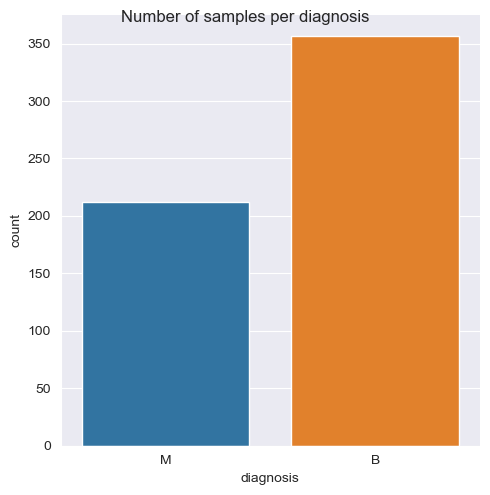

In [23]:
#code reused from my machine learning coursework
plot = sns.catplot(data=df, x='diagnosis', kind='count')
plot.fig.suptitle('Number of samples per diagnosis')
plt.show()

#encoding the diagnosis feature since it categorical
df['diagnosis'] = df.diagnosis.replace({'M': 0,'B':1})